In [1]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, delete_items
from scripts.utils.cal_crai_calculations import process_domain_csv_files
from scripts.utils.cal_crai_plotting import index_plot, plot_region_domain, plot_domain_score

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = ''
input_folder = r'aws_csvs'
output_folder = "all_metrics_folder"
meta_csv = r'../utils/calcrai_metrics.csv'
meta_csv = r'scripts/utils/calcrai_metrics.csv'

merged_output_file = f'concatenate_{domain_prefix}metrics.csv'
metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 110 CSV files within the '' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN.
Processed CSV saved as concatenate_metrics.csv


In [4]:
cal_crai_metrics_merged = pd.read_csv('concatenate_metrics.csv')

In [5]:
cal_crai_metrics_merged

,GEOID,low_internet_download_flag,cellular_towers_data_count,percent_underground_transmission_lines,percent_housing_before_1980,percent_mobile_homes,percent_without_kitchen_facilities_or_plumbing,estimated_total_vacant_housing_units,microwave_towers_data_count,mobile_towers_data_count,...,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,0.0,2.0,0.0,15.032680,2.0,0.0,119.0,734.0,28.0,...,11.200000,2.0,1.200000,3.850000,64.306645,0.919842,10.400000,4.823653,72.674237,0.275314
1,6001400200,0.0,2.0,0.0,90.639269,0.0,0.6,37.0,734.0,28.0,...,4.000000,0.0,0.000000,4.050000,64.306645,1.595745,10.600000,3.000000,72.674237,0.838379
2,6001400300,0.0,2.0,0.0,82.714177,0.0,0.0,213.0,734.0,28.0,...,8.900000,0.0,8.000000,3.780000,64.306645,1.152702,10.300000,3.900000,72.674237,1.655099
3,6001400400,0.0,2.0,0.0,92.159091,0.0,0.6,215.0,734.0,28.0,...,14.800000,0.0,0.900000,4.440000,64.306645,2.146272,21.100000,2.500000,72.674237,2.244039
4,6001400500,0.0,2.0,0.0,89.874926,0.0,0.0,141.0,734.0,28.0,...,14.800000,0.0,1.700000,3.640000,64.306645,3.771252,21.900000,3.800000,72.674237,4.482147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,3.0,0.0,14.730290,0.0,2.7,14.0,45.0,NaN,...,35.200000,0.0,5.916667,4.330000,1.725293,6.049022,28.300000,3.400000,49.063183,1.445396
9125,6115041001,1.0,3.0,0.0,43.787777,14.8,11.5,106.0,45.0,NaN,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,2.777778
9126,6115041002,1.0,3.0,0.0,33.126294,6.0,0.0,183.0,45.0,NaN,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,15.510682
9127,6115041101,1.0,3.0,0.0,44.197292,28.8,1.5,384.0,45.0,NaN,...,19.722222,3.0,5.916667,4.863333,1.725293,11.883790,48.111111,9.388889,49.063183,7.430070


In [6]:
def calculate_missing_percentage_and_columns(df, geoid_column='GEOID'):
    """
    Calculates the percentage of missing entries and lists missing column names for each GEOID in the given DataFrame.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the GEOID and other columns.
    geoid_column : str
        The name of the column representing GEOIDs.
    
    Returns:
    -------
    pd.DataFrame
        A new DataFrame with GEOID, the percentage of missing entries, and a list of missing columns for each GEOID.
    """
    # Ensure the GEOID column exists in the DataFrame
    if geoid_column not in df.columns:
        raise ValueError(f"Column '{geoid_column}' not found in the DataFrame.")
    
    # Group by GEOID to handle duplicates
    grouped = df.groupby(geoid_column)

    # Calculate the percentage of missing values for each GEOID
    missing_percentage = grouped.apply(lambda g: g.isnull().mean(axis=1).mean() * 100)

    # Identify missing columns for each GEOID
    missing_columns = grouped.apply(lambda g: g.columns[g.isnull().any()].tolist())

    # Create a new DataFrame with GEOID, missing percentage, and missing columns
    result_df = pd.DataFrame({
        geoid_column: missing_percentage.index,
        'missing_percentage': missing_percentage.values,
        'missing_columns': missing_columns.values
    })
    
    return result_df


In [7]:
skrt = calculate_missing_percentage_and_columns(cal_crai_metrics_merged)

C:\Users\jespi\AppData\Local\Temp\ipykernel_26904\3721991175.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_percentage = grouped.apply(lambda g: g.isnull().mean(axis=1).mean() * 100)
C:\Users\jespi\AppData\Local\Temp\ipykernel_26904\3721991175.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_columns = grouped.apply(lambda g: g.columns[g.isnull().any()].tolist())


In [8]:
pd.set_option('display.max_colwidth', None)  # Show full column width


In [24]:
skrt.missing_percentage.max()

99.09909909909909

In [10]:
display(skrt)

,GEOID,missing_percentage,missing_columns
0,6001400100,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]"
1,6001400200,8.108108,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, protected_areas_percentage, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]"
2,6001400300,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]"
3,6001400400,7.207207,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]"
4,6001400500,6.306306,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric]"
...,...,...,...
9124,6115040902,17.117117,"[mobile_towers_data_count, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, rcp_4.5__50th_percent_change, percent_unhealthy_air_quality, blood and organ banks per 10000 people, hospitals per 10000 people, avg_hpsscore_mental_shortage_metric, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric]"
9125,6115041001,18.918919,"[mobile_towers_data_count, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, rcp_4.5__50th_percent_change, percent_unhealthy_air_quality, blood and organ banks per 10000 people, hospitals per 10000 people, avg_hpsscore_mental_shortage_metric, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, asthma_related_ed_visits_per_10000_people_2019, cardiovascular_disease_related_ed_visits_per_10000_people_2019]"
9126,6115041002,18.918919,"[mobile_towers_data_count, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, rcp_4.5__50th_percent_change, percent_unhealthy_air_quality, blood and organ banks per 10000 people, hospitals per 10000 people, avg_hpsscore_mental_shortage_metric, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, asthma_related_ed_visits_per_10000_people_2019, cardiovascular_disease_related_ed_visits_per_10000_people_2019]"
9127,6115041101,18.918919,"[mobile_towers_data_count, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_

In [15]:
# GEOID handling
skrt['GEOID'] = skrt['GEOID'].apply(lambda x: '0' + str(x))
skrt['GEOID'] = skrt['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

In [11]:
import numpy as np

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you already have your `ca_boundaries` shapefile loaded
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)

In [25]:
def missing_data_plot(df, 
                      column='missing_percentage', 
                      scenario=None, 
                      plot_title=False, 
                      save_name=None, 
                      plot_type='continuous', 
                      vmin=0, 
                      vmax=100, 
                      threshold=0):
    '''
    Maps the missing data percentage for each GEOID across the state, with an option to filter based on a threshold.
    
    Parameters
    ----------
    df : DataFrame
        Input DataFrame containing the missing percentage data for each GEOID.
    column : str
        The column in the DataFrame containing the missing percentage data.
    scenario : str
        Default is None. If you want to add a scenario-specific title.
    plot_title : bool
        Default is False. Set to True if you want a plot title.
    save_name : str
        Default is None. If provided, the plot will be saved with this name.
    plot_type : str
        Specifies the type of mapping for the plot.
        - 'continuous': Uses a gradient to represent a smooth range of values.
        - 'discrete': Uses distinct colors to represent the binned data.
    vmin : int
        Minimum value for the color scale (Default is 0).
    vmax : int
        Maximum value for the color scale (Default is 100).
    threshold : int
        Minimum percentage to display on the plot. Data points with missing data below this threshold will be excluded.
    '''
    
    # Ensure GEOID is treated as a string in both dataframes
    df['GEOID'] = df['GEOID'].astype(str)
    ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)
    
    # Handle NaN or infinite values in the column
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert to numeric and force errors to NaN
    
    # Check for infinite values and replace them with NaN
    num_infinite = np.isinf(df[column]).sum()
    print(f"\nNumber of infinite entries in column '{column}': {num_infinite}")
    print('Replacing infinite entries (if any) with NaN.')
    df[column] = df[column].replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
    
    # Handle NaN values
    df[column] = df[column].fillna(0)  # Replace NaNs with 0 (or any other value you prefer)

    # Apply threshold filtering
    df = df[df[column] > threshold]  # Filter rows based on the threshold

    # Merging with geographical boundaries
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry']
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)
    
    if not df2.is_valid.all():
        print("Some geometries are invalid.")
        df2 = df2[df2.is_valid]

    # Set up figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 8), layout='compressed')

    # Check plot type and set plotting parameters accordingly
    if plot_type == 'discrete':
        # For discrete values (0-100), use discrete colormap
        df2.plot(column=column, ax=ax, legend=True, cmap='YlGnBu', categorical=True)
        ax.get_legend().set_title("Percentage Missing")

    else:
        # For continuous values, use continuous colormap
        sm = df2.plot(column=column, ax=ax, vmin=vmin, vmax=vmax, cmap='YlGnBu', legend=True)

        # Create a colorbar manually and set the title
        cbar = fig.colorbar(sm.collections[0], ax=ax, orientation='horizontal')
        cbar.set_label("Percentage Missing")

    # Set aspect ratio to 'auto' for proper scaling of map
    ax.set_aspect('auto')  # Use 'auto' to let matplotlib choose the best aspect

    # Annotation for scenario
    if scenario is None:
        plt.annotate('Missing Data Percentage', xy=(0.02, 0.02), xycoords='axes fraction')
    else:
        plt.annotate(f'Missing Data for {scenario}', xy=(0.02, 0.02), xycoords='axes fraction')
        if plot_title == True:
                ax.set_title(f'Missing Data: {scenario.title()}', fontsize=16.5)

    # Save figure if required
    if save_name:
        fig.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')  # Save the figure

    plt.show()  # Show the plot



Number of infinite entries in column 'missing_percentage': 0
Replacing infinite entries (if any) with NaN.


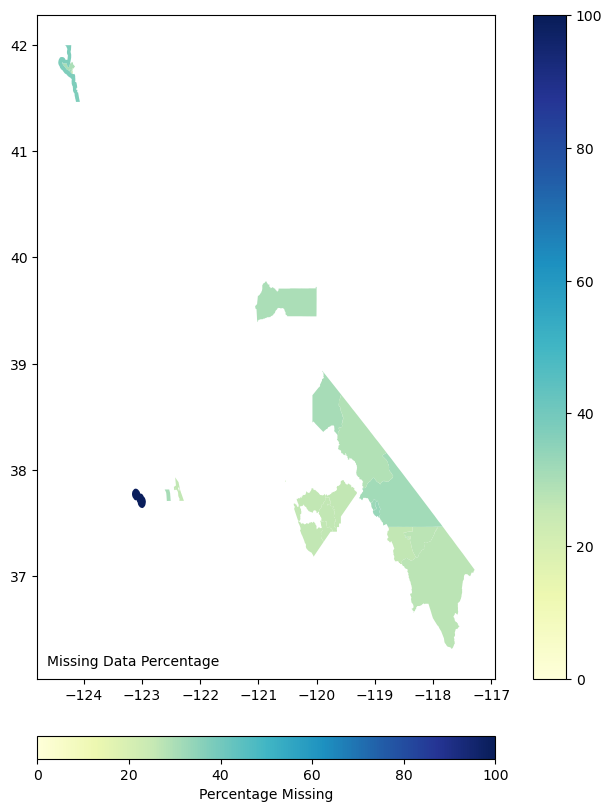

In [29]:
missing_data_plot(skrt, column='missing_percentage', threshold=25)